## Load Data

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display_functions import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

df = pd.read_csv('../data/dmoz.csv', header=None)
df.columns = ["index", "url", "label"]

print(f'Dropping {df.url.isnull().sum()} empty URL entries from ODP dataset')
df.drop(df[df.url.isnull()].index, inplace=True)
print(f'Dropping {df.label.isnull().sum()} empty label entries from ODP dataset')
df.drop(df[df.label.isnull()].index, inplace=True)

Dropping 3 empty URL entries from ODP dataset
Dropping 0 empty label entries from ODP dataset


## Preprocessing

In [4]:
df['url'] = df['url'].apply(lambda x: np.str_(x))

## Prepare labels

<Axes: xlabel='label'>

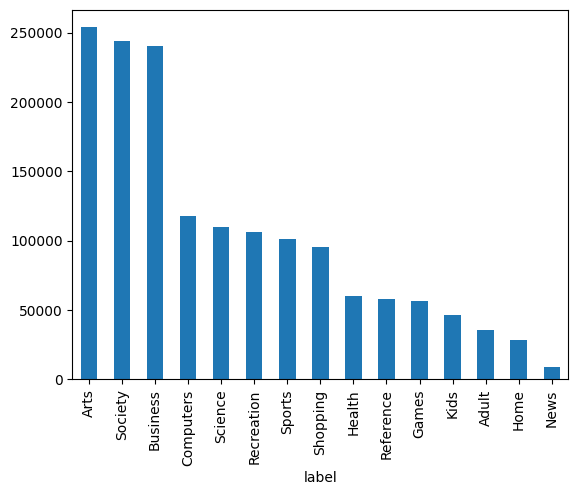

In [5]:
labels = list(set(df['label']))
labels.sort()
label2id = {l: n for n, l in enumerate(labels)}
id2label = {n: l for n, l in enumerate(labels)}
df['label_id'] = df['label'].map(label2id)
df['label'].value_counts().plot(kind='bar')

## Transform with count vectorizer

In [6]:
count_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5))
X = count_vectorizer.fit_transform(df['url'])
y = df['label'].values

X, y = shuffle(X, y, random_state=67)

## Optimize alpha parameter with grid search

In [7]:
sgd = SGDClassifier(class_weight='balanced', loss='hinge')

dist = {'alpha': np.logspace(-7, 2, 10)}
clf = RandomizedSearchCV(sgd, param_distributions=dist, random_state=67, n_jobs=4, cv=2)

start = time.time()
search = clf.fit(X, y)
print(f'\nCV Time: {time.time()-start}')
search.best_params_


CV Time: 354.5315179824829


{'alpha': 1e-05}

## Report results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,59.589820,0.058734,1.793670,0.071380,0.00001,{'alpha': 1e-05},0.581726,0.587790,0.584758,0.003032,1
1,90.529234,0.477167,1.604732,0.110815,0.000001,{'alpha': 1e-06},0.574976,0.574050,0.574513,0.000463,2
0,156.505824,1.547841,1.534658,0.065159,0.0,{'alpha': 1e-07},0.561557,0.560627,0.561092,0.000465,3
3,37.254384,0.268085,2.024655,0.013436,0.0001,{'alpha': 0.0001},0.559457,0.548474,0.553965,0.005492,4
4,27.457266,0.311193,1.612944,0.048806,0.001,{'alpha': 0.001},0.507801,0.513283,0.510542,0.002741,5
5,28.954498,0.127862,1.764160,0.097499,0.01,{'alpha': 0.01},0.466345,0.469937,0.468141,0.001796,6
6,25.185214,0.349981,1.666414,0.005934,0.1,{'alpha': 0.1},0.450624,0.458836,0.454730,0.004106,7
7,26.542323,0.030326,1.526426,0.017725,1.0,{'alpha': 1.0},0.324070,0.325222,0.324646,0.000576,8
8,38.626801,0.438547,1.853968,0.073522,10.0,{'alpha': 10.0},0.243012,0.258784,0.250898,0.007886,9
9,31.655617,0.381811,1.047938,0.115262,100.0,{'alpha': 100.0},0.230317,0.224014,0.227165,0.003152,10


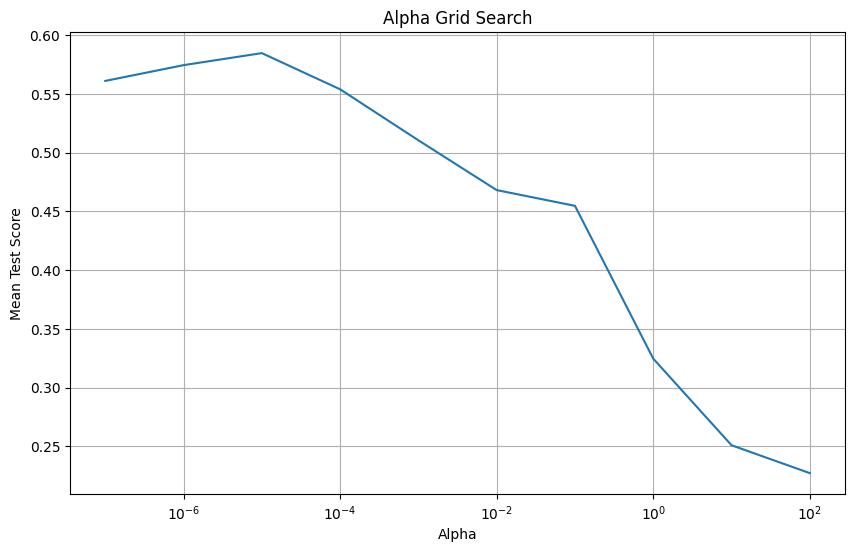

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(clf.cv_results_).sort_values('rank_test_score'))

plt.figure(figsize=(10, 6))
plt.semilogx(clf.cv_results_['param_alpha'], clf.cv_results_['mean_test_score'])
plt.title('Alpha Grid Search')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.grid()
plt.savefig("../results/charts/dmoz-gridsearch.png")
plt.show()

## Evaluate best model

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

y_pred = cross_val_predict(clf.best_estimator_, X, y)

print(classification_report(y, y_pred, labels=labels))

df['prediction'] = y_pred
df.to_csv('../results/phishstorm-predictions.csv', index=False)

              precision    recall  f1-score   support

       Adult       0.50      0.76      0.61     35325
        Arts       0.71      0.60      0.65    253840
    Business       0.63      0.55      0.58    240176
   Computers       0.59      0.57      0.58    117961
       Games       0.55      0.63      0.59     56477
      Health       0.56      0.63      0.59     60097
        Home       0.46      0.64      0.54     28269
        Kids       0.36      0.47      0.41     46182
        News       0.18      0.51      0.26      8989
  Recreation       0.48      0.56      0.52    106586
   Reference       0.54      0.65      0.59     58247
     Science       0.63      0.59      0.61    110286
    Shopping       0.41      0.48      0.44     95270
     Society       0.74      0.60      0.66    243942
      Sports       0.68      0.73      0.70    101328

    accuracy                           0.59   1562975
   macro avg       0.54      0.60      0.56   1562975
weighted avg       0.61   

## Confusion matrix

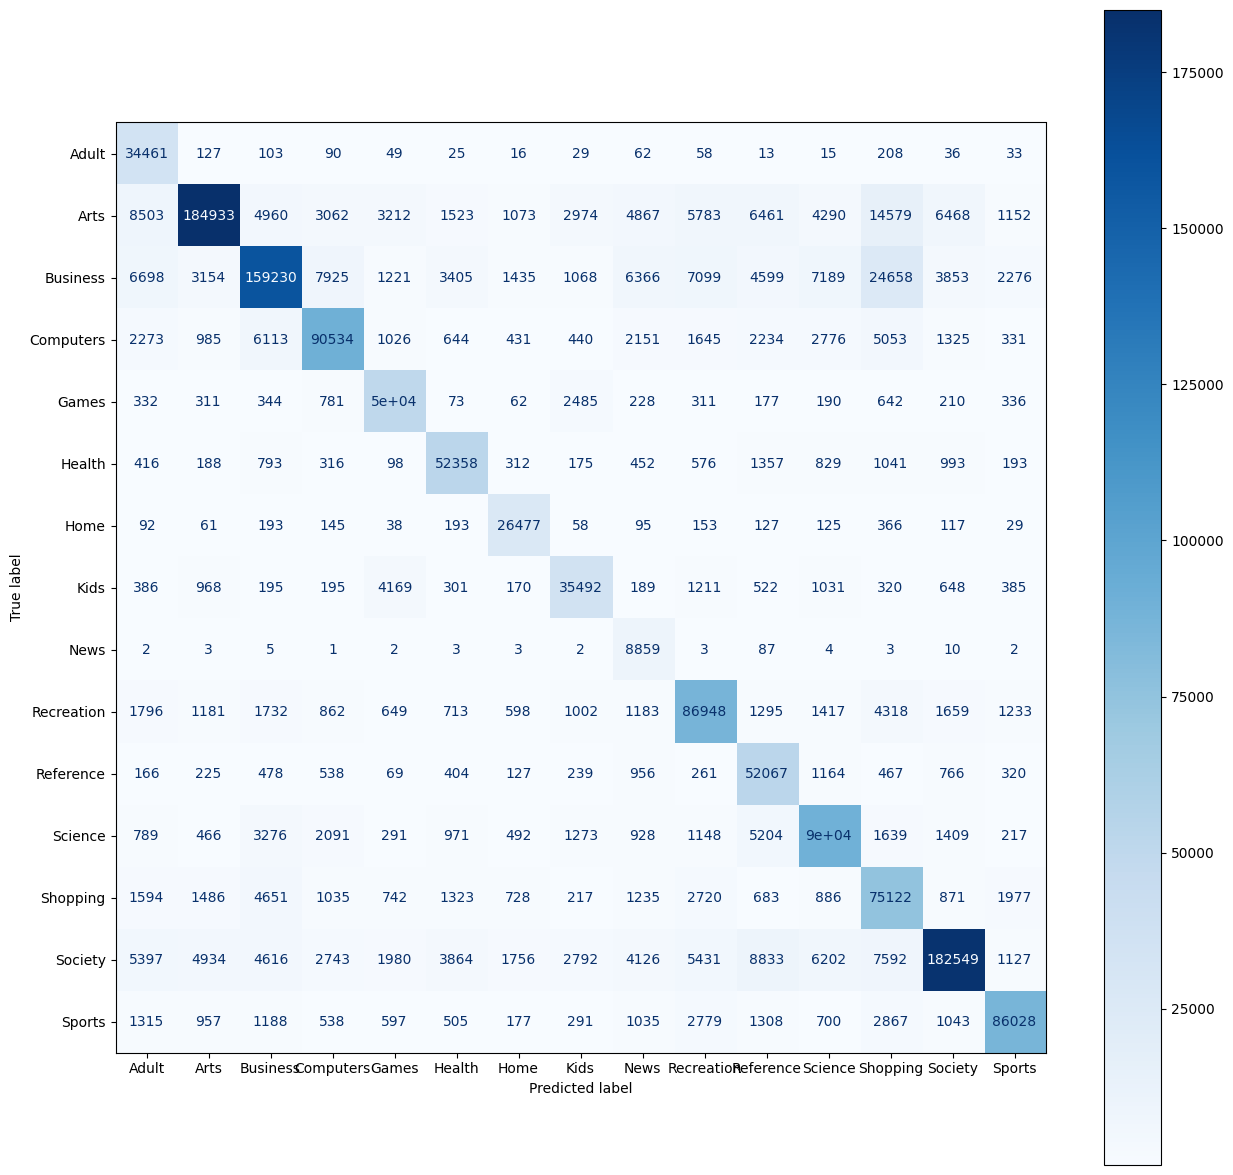

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

_, ax = plt.subplots(figsize=(15,15))
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X,
    y,
    display_labels=labels,
    cmap=plt.cm.Blues,
    ax=ax
)
plt.savefig('../results/charts/dmoz-confusion-matrix.png')
plt.show()

## Write predictions to CSV

In [11]:
df['prediction_ids'] = y_pred
df['predictions'] = df['prediction_ids'].map(id2label)
df = df[['url', 'label', 'prediction']]
df.to_csv('../results/predictions/dmoz-predictions.csv', index=False)